# Analysis of our data

1. Data collecting and data cleaning 
2. Computations for the creation of the adjacency matrix and the graph
3. Graph creation
4. Analysis

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas.io.json import json_normalize
import pickle
import re
import scipy as sp
from scipy import stats
from scipy import sparse
import scipy.sparse.linalg
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import nltk
import omdb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None

In [2]:
%matplotlib inline

# 1. Data collecting and data cleaning

In [3]:
#import dataset
FILE_PATH_CREW = "../Data/tmdb_5000_credits.csv"

features_crew = pd.read_csv(FILE_PATH_CREW)

# Dataframe with info about the movies
features_crew.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
#specify your API_KEY used to set client
API_y_KEY = '3a7e30ce'
omdb.set_default('apikey', API_y_KEY)
client = omdb.OMDBClient(apikey=API_y_KEY)

In [ ]:
#We have a 1000 request limit so you can decide here at which film you want to start and where to end 
id_end = 4803
id_start = id_end - 1000

In [ ]:
#creates empty dictionary then updates it using the movie_id as a key and the output of the
#request as value (note that that res.content isn't actually a dict but a byte object, we may
#need to convert it later)

collected = dict()

for i in range(id_start, id_end):
    title = features_crew.title[i]
    res = omdb.request(t=title, tomatoes=True)
    movie_json = res.content
    collected[str(features_crew.movie_id[i])] = movie_json

In [ ]:
# saves collected as pickle
with open('metacrit.p', 'wb') as fp:
    pickle.dump(collected, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
# loads collected
with open('metacrit.p', 'rb') as fp:
    test_data = pickle.load(fp)

# 2. Computations for the creation of the adjacency matrix and the graph

In [4]:
df = pd.DataFrame.from_dict(test_data, orient='index')
df.head()

,0
19995,"b'{""Title"":""Avatar"",""Year"":""2009"",""Rated"":""PG-..."
285,"b'{""Title"":""Pirates of the Caribbean: At World..."
206647,"b'{""Title"":""Spectre"",""Year"":""2015"",""Rated"":""PG..."
49026,"b'{""Title"":""The Dark Knight Rises"",""Year"":""201..."
49529,"b'{""Title"":""John Carter"",""Year"":""2012"",""Rated""..."


In [515]:
dataframe = pd.read_json(df.iloc[0].values[0])

for i in range(1, len(df)):
    if len(df.iloc[i].values[0]) > 100:
        movie = pd.read_json(df.iloc[i].values[0])
    dataframe = pd.concat([dataframe, movie])

In [516]:
# We decided to drop the useless columns that did not contain information about the movie
# These columns are: - urls (Poster, Website, tomatoImage)
#                    - columns related to the API (Response, Type)
#                    - columns where all entries are NaN
#                    - Irrelevant columns (DVD, ie release date of dvd, Runtime, Released, Year, Country, Language, 
#                                          imdbVotes)
#                    - Redundant columns (imdbID is redundant with Title)

dataframe = dataframe.drop(columns=['Poster', 'Response', 'Type', 'Website', 'tomatoConsensus', 
                                    'tomatoFresh', 'tomatoImage', 'tomatoMeter', 'tomatoRating', 
                                    'tomatoReviews', 'tomatoRotten', 'tomatoURL', 'tomatoUserMeter', 
                                    'tomatoUserRating', 'tomatoUserReviews', 'totalSeasons', 'DVD', 
                                    'Year', 'imdbID', 'Runtime', 'Released', 'Country', 'Language', 'imdbVotes'])
dataframe.head()

,Actors,Awards,BoxOffice,Director,Genre,Metascore,Plot,Production,Rated,Ratings,Title,Writer,imdbRating
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000",James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",Avatar,James Cameron,7.8
1,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000",James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '82%'}",Avatar,James Cameron,7.8
2,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000",James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Metacritic', 'Value': '83/100'}",Avatar,James Cameron,7.8
0,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,"$309,404,152",Gore Verbinski,"Action, Adventure, Fantasy",50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",7.1
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,"$309,404,152",Gore Verbinski,"Action, Adventure, Fantasy",50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '44%'}",Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",7.1


We now need to transform the types so that it is easier to analyze the features. As of now, almost all the entries of our dataframe are strings. We have a few entries that are integer numbers that need to be converted: BoxOffice and Metascore.

Metascore is already in an appropriate format, we just need to cast the type. However, BoxOffice needs a little bit of tinkering.

In [517]:
# For BoxOffice we need to remove the $ and commas
dataframe['BoxOffice'] = dataframe['BoxOffice'].apply(lambda x: x.replace("$", ""))
dataframe['BoxOffice'] = dataframe['BoxOffice'].apply(lambda x: x.replace(",", ""))
dataframe['BoxOffice'] = dataframe['BoxOffice'].replace('N/A', np.nan)
dataframe['BoxOffice'] = dataframe['BoxOffice'].astype(float)
dataframe = dataframe.dropna()
dataframe['BoxOffice'] = dataframe['BoxOffice'].astype(int)
# Metascore
dataframe['Metascore'] = dataframe['Metascore'].replace('N/A', np.nan)
dataframe = dataframe.dropna()
dataframe['Metascore'] = dataframe['Metascore'].astype(int)

In [518]:
dataframe.head()

,Actors,Awards,BoxOffice,Director,Genre,Metascore,Plot,Production,Rated,Ratings,Title,Writer,imdbRating
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",Avatar,James Cameron,7.8
1,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '82%'}",Avatar,James Cameron,7.8
2,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Metacritic', 'Value': '83/100'}",Avatar,James Cameron,7.8
0,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,Gore Verbinski,"Action, Adventure, Fantasy",50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",7.1
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,Gore Verbinski,"Action, Adventure, Fantasy",50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '44%'}",Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",7.1


Now, we need to regroup the different sources of ratings so that the movies are not repeated three times in the dataframe.

- The first rating comes from imdb. It is already present in the dataframe under the name imdbRating
- The second rating comes from Rotten Tomatoes. It is not present in the dataframe yet, we need to retrieve it from Ratings
- The third rating comes from Metacritic. It is already present in the dataframe under the name Metascore.

The only rating we need to keep from Ratigs is the grade from Rotten Tomatoes. We will hence remove all the rows containing ratings only from imdb or metacritics and then rename the Ratings column. 

We wish to separate this column into 3 columns, drop the duplicate rows and convert the ratings to percentages for a more uniform notation.

In [519]:
dataframe_ = dataframe.copy()

In [520]:
def transform_tomatograde(strgrade):
    if '/10' in strgrade:
        grade = strgrade.replace('/10', '').replace('.', '')
    elif '%' in strgrade:
        grade = strgrade.replace('%', '')
    elif '/100' in dataframe_['metacriticGrade'][i]:
        grade = strgrade.replace('/100', '')
    else:
        grade = float(dataframe_['tomatoGrade'][i])
        if grade > 100:
            grade = grade / 10
    
    return int(grade)   

In [521]:
# 1. Extract the Rotten Tomatoes grade
dataframe_['RatingIndex'] = dataframe_.index
dataframe_ = dataframe_.reset_index(drop=True)
dataframe_['tomatoGrade'] = np.nan
for i in range(len(dataframe_[dataframe_.RatingIndex == 1])):
    title = dataframe_[dataframe_.RatingIndex == 1].iloc[i].Title
    idx = dataframe_[dataframe_.Title == title].index[0]
    grade = transform_tomatograde(dataframe_[dataframe_.RatingIndex == 1].iloc[i].Ratings['Value'])
    dataframe_.at[idx, 'tomatoGrade'] = grade
dataframe_ = dataframe_[dataframe_.RatingIndex == 0]
dataframe_ = dataframe_.drop(columns=['RatingIndex'])

# 2. Rename the Metacritics and imdb grades
dataframe_ = dataframe_.rename(columns={'imdbRating' : 'imdbGrade', 'Metascore' : 'metacriticGrade'})

# 3. Drop NaN
dataframe_ = dataframe_.dropna()

# 4. Transform grades
dataframe_['imdbGrade'] = dataframe_['imdbGrade']*10
dataframe_['imdbGrade'] = dataframe_['imdbGrade'].astype(int)
dataframe_['tomatoGrade'] = dataframe_['tomatoGrade'].astype(int)
dataframe_['metacriticGrade'] = dataframe_['metacriticGrade'].astype(int)

# 5. Reset index
dataframe_ = dataframe_.reset_index(drop=True)

# 6. Drop the Ratings column
dataframe_ = dataframe_.drop(columns=['Ratings'])

In [522]:
dataframe_.head()

,Actors,Awards,BoxOffice,Director,Genre,metacriticGrade,Plot,Production,Rated,Title,Writer,imdbGrade,tomatoGrade
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,James Cameron,"Action, Adventure, Fantasy, Sci-Fi",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,Avatar,James Cameron,78,82
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,Gore Verbinski,"Action, Adventure, Fantasy",50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",71,44
2,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra...",Won 1 Oscar. Another 7 wins & 32 nominations.,208777731,Sam Mendes,"Action, Adventure, Thriller",60,A cryptic message from 007's past sends him pi...,Sony Pictures,PG-13,Spectre,"John Logan (screenplay by), Neal Purvis (scree...",68,64
3,"Christian Bale, Gary Oldman, Tom Hardy, Joseph...",Nominated for 1 BAFTA Film Award. Another 38 w...,448130642,Christopher Nolan,"Action, Thriller",78,Eight years after the Joker's reign of anarchy...,Warner Bros. Pictures,PG-13,The Dark Knight Rises,"Jonathan Nolan (screenplay), Christopher Nolan...",84,87
4,"Taylor Kitsch, Lynn Collins, Samantha Morton, ...",2 wins & 8 nominations.,73058679,Andrew Stanton,"Action, Adventure, Sci-Fi",51,"Transported to Barsoom, a Civil War vet discov...",Walt Disney Pictures,PG-13,John Carter,"Andrew Stanton (screenplay by), Mark Andrews (...",66,51


Now, we need to deal with the string attributes that are in form of a list. We want a set of strings, each string corresponding to an individual characteristic (director, actor, etc).

In order to do so, we split the string at the commas. For the Writer attribute, we decided to remove the specifications and only keep the names of the writers, taking off who wrote the story, screenplay or characters.

In [523]:
dataframe_['Actors'] = dataframe_['Actors'].apply(lambda x: set(x.split(', ')))
dataframe_['Director'] = dataframe_['Director'].apply(lambda x: set(x.split(', ')))
dataframe_['Genre'] = dataframe_['Genre'].apply(lambda x: set(x.split(', ')))
dataframe_['Writer'] = dataframe_['Writer'].apply(lambda x: re.sub(" [\(\[].*?[\)\]]", "", x))
dataframe_['Writer'] = dataframe_['Writer'].apply(lambda x: set(x.split(', ')))

Now, we deal with the Production company. We have observed that a same company has different names within this dataset, sometimes the names diferring only by a space or an add-on (like "distribution"). We want to uniformize this. First, we remove all the words such as "Company" or "Industries" so that all production companies have only their core name. 

In [524]:
to_remove = [' Corporation', ' Distribution', ' Corporat', ' Production', ' Films', ' Film', 
             ' Pictures', ' Picutres', ' Internationa', ' International', ' Industries', ' Compa', 
             ' Co', ' Distribu', ' Studios', ' Animation', ' Feature', ' SKG', ' LLC', ' Recommends', 
             ' Digital', ' Media', ' Video', ' Inc', ' Home Entertainment', ' Entertainment', ' Lorber', 
             ' Releasing', ' Cinema.', ' Cinema', ' Classics', ' Classic', ' Group', ' Europacorp', 
             ' Pvt. Ltd.', ' Ventures', ' [us]', ' Pictur', ' Home', ' Focus', ' City', ' Atomic', 
             ' Faith', ' Searchlight', ' Walden', '.', ' TriStarl', ' TriStar', ' Tristar']
for word in to_remove:
    dataframe_['Production'] = dataframe_['Production'].str.replace(word, '')

Next, we replace all misspelled or differently spelled company names by one spelling. 

In [525]:
dataframe_['Production'] = dataframe_['Production'].str.replace('-', ' ')
dataframe_['Production'] = dataframe_['Production'].str.replace(' / ', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace(' /', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace('/ ', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace('DreamWorks', 'Dreamworks')
dataframe_['Production'] = dataframe_['Production'].str.replace('Dream Works', 'Dreamworks')
dataframe_['Production'] = dataframe_['Production'].str.replace("Lion's Gate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("Liongate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("Lions Gate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("LionsGate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace('Metro Goldwyn Mayer (MGM)', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace('Metro Goldwyn Mayer', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace('WARNER BROTHERS PICTURES', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('WB', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Weinsteinny', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Brothers', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Home', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Independent', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('PIXAR', 'Pixar')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warners Bros', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Universall', 'Universal')
dataframe_['Production'] = dataframe_['Production'].str.replace('The Weinstein', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Vantage', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace('/lumbia', '/ Columbia')
dataframe_['Production'] = dataframe_['Production'].str.replace('MGM (MGM)', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace(' First Take', '/ Columbia')
dataframe_['Production'] = dataframe_['Production'].str.replace('Goodbye Cruel', 'Goodbye Cruel World')
dataframe_['Production'] = dataframe_['Production'].str.replace('FoxFaith', 'Fox')
dataframe_['Production'] = dataframe_['Production'].str.replace('Fine Line', 'Fine Lines')
dataframe_['Production'] = dataframe_['Production'].str.replace('Erosl', 'Eros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Walt Disneys', 'Disney')
dataframe_['Production'] = dataframe_['Production'].str.replace('Walt Disney', 'Disney')

In [526]:
dataframe_['Production'] = dataframe_['Production'].apply(lambda x: set(x.split('/')))

Now, we deal with the plot. For this NLP task, we will keep it simple. We only kept the common nouns (singular or plural).

In [527]:
def find_nouns(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNS')]
    return set(nouns)

In [528]:
dataframe_['Plot'] = dataframe_['Plot'].apply(lambda x: find_nouns(x))

We need to format the Awards feature. The current Awards column contains a string (sentence) describing how many awards the movie has won or has been nominated to. It also specifies if it has won or been nominated to Oscars or BAFTA. We believe that when it is specified, the higher "award" is listed, i.e. if the movie won 2 Oscars, the 5 Oscar nominations won't be specified. The most useful format we could think of is to transform this award column into 2 distinct columns, since we cannot infer how many nominations to the Oscars a movie has when it has already won some. The columns are hence: 

- Wins
- Nominations

In [529]:
def find_wins_nominations(string):
    wins = 0
    noms = 0
    
    splitted = string.split('. ')
    if len(splitted) > 1:
        string1 = splitted[0]
        if re.search('nominated', string1, re.IGNORECASE):
            noms = noms + int(string1.split(' ')[2])
        if re.search('won', string1, re.IGNORECASE):
            wins = noms + int(string1.split(' ')[1])
        
        string2 = splitted[1]
        if re.search('nomination', string2, re.IGNORECASE):
            noms = noms + int(string2.split(' nomination')[0].split(' ')[-1])
        if re.search('win', string2, re.IGNORECASE):
            wins = wins + int(string2.split(' win')[0].split(' ')[-1])
    elif len(splitted) == 1:
        split_string = splitted[0]
        if re.search('nomination', split_string, re.IGNORECASE):
            noms = noms + int(split_string.split(' nomination')[0].split(' ')[-1])
        if re.search('win', split_string, re.IGNORECASE):
            wins = wins + int(split_string.split(' win')[0].split(' ')[-1])
    return wins, noms

In [530]:
dataframe_['Wins'] = 0
dataframe_['Nominations'] = 0

for i in range(0, len(dataframe_)):
    wins, noms = find_wins_nominations(dataframe_.Awards[i])
    dataframe_['Wins'][i] = wins
    dataframe_['Nominations'][i] = noms
dataframe_ = dataframe_.drop(columns='Awards')

The Rated attribute is not uniform and has multiple conventions. We seek to normalize it. We decided to use the Motion Picture Association of America film rating system, which states that:

- **G: General Audiences. All ages admitted.** Nothing that would offend parents for viewing by children.
- **PG: Parental Guidance Suggested.** Some material may not be suitable for children. Parents urged to give "parental guidance". May contain some material parents might not like for their young children.
- **PG-13: Parents Strongly Cautioned.** Some material may be inappropriate for children under 13. Parents are urged to be cautious. Some material may be inappropriate for pre-teenagers.
- **R: Restricted. Under 17 requires accompanying parent or adult guardian.** Contains some adult material. Parents are urged to learn more about the film before taking their young children with them.
- **NC-17: Adults Only.** No One 17 and Under Admitted. Clearly adult. Children are not admitted.

https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system

**X** rating means persons under 16 not admitted. For our analysis, we decided to conflate that label within **NC-17**

Following this, we need to make some modifications: 

- Approved -> G
- GP -> PG
- M -> R
- Passed -> G
- TV-14 -> PG-13
- TV-G -> G
- TV-MA -> R
- TV-PG -> PG
- X -> NC-17
- Unrated, Not rated and N/A make up their own category **Unrated**

In [531]:
# Replacing all differently rated categories by the standard ones
dataframe_['Rated'] = dataframe_['Rated'].str.replace('APPROVED', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('GP', 'PG')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('M', 'R')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('PASSED', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-14', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('APPROVED', 'PG-13')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-G', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-MA', 'R')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-PG', 'PG')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('X', 'NC-17')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('NOT RATED', 'UNRATED')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('N/A', 'UNRATED')

In [532]:
dataframe_['Rated'] = dataframe_['Rated'].apply(lambda x: {x})

In [533]:
dataframe_.to_pickle("df.pkl")

In [534]:
dataframe_ = pd.read_pickle("df.pkl")

Finally, we need to add the budget. For that, we use the budget column in the Kaggle imdb dataset.

In [535]:
FILE_PATH_MOVIE = "../Data/tmdb_5000_movies.csv"
movie_df = pd.read_csv(FILE_PATH_MOVIE)

budget_df = movie_df[['budget', 'title']]
budget_df = budget_df.rename(columns={"budget" : "Budget", "title" : "Title"})

final_df = dataframe_.merge(budget_df, how='inner')

In [536]:
# Budget is weirdly formatted: there are movies that state a single number budget to signify its millions.
# Let's unify it

final_df['Budget'].iloc[1971] = final_df['Budget'].iloc[1971] * 10**6
final_df['Budget'].iloc[1608] = final_df['Budget'].iloc[1608] * 10**6
final_df['Budget'].iloc[2330] = final_df['Budget'].iloc[2330] * 10**6
final_df['Budget'].iloc[1861] = 5500000
final_df['Budget'].iloc[2310] = 650000
final_df['Budget'].iloc[764] = 45000000
final_df['Budget'].iloc[2349] = 153000

# Moreover, we have budgets that are 0. We will replace these as np.nan then drop the whole row
final_df['Budget'] = final_df['Budget'].apply(lambda x: np.nan if x==0 else x)

In [537]:
final_df = final_df.dropna()

Now, Budget is a continuous variable. We decided to create categories so as to sparsify the network. We did this by looking at the histogram and by taking into account the usual budget categories: 

- No budget: less than 100 000 \$
- Independent: 100 000 to 10 million \$
- Low: 10 to 40 million \$
- Medium: 41 to 100 million \$
- High: 101 million and up \$

Since these are ordinal categories, each will be coded with an integer (ranging from 1 to 5). 

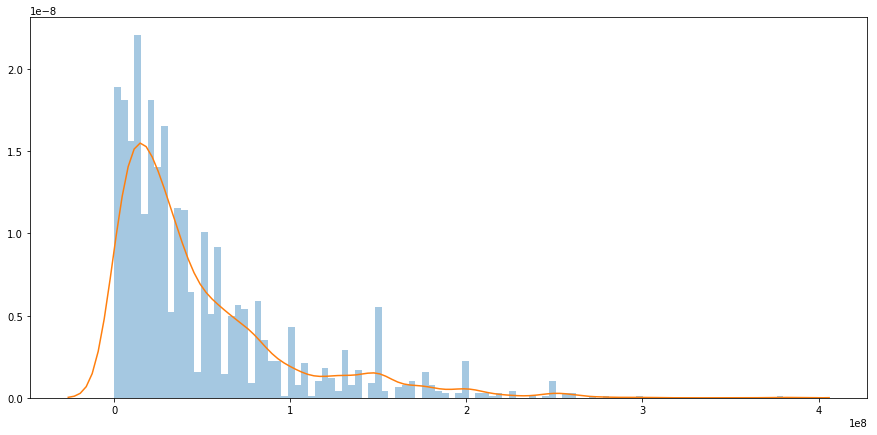

In [538]:
plt.figure(figsize=(15,7))
sns.distplot(final_df['Budget'].dropna().values, kde=False, norm_hist=True, bins=100)
sns.kdeplot(final_df['Budget'].dropna().values, kernel='gau')
plt.show()

In [539]:
# No budget: less than 100 000 
# Independent: 100 000 to 10 million 
# Low: 10 to 40 million 
# Medium: 41 to 100 million 
# High: 101 million and up 

def transform_budget(budget):
    if budget < 100000:
        budget_cat = 1
    elif budget >= 100000 and budget < 10000000:
        budget_cat = 2
    elif budget >= 10000000 and budget < 40000000:
        budget_cat = 3
    elif budget >= 40000000 and budget < 100000000:
        budget_cat = 4
    elif budget >= 100000000:
        budget_cat = 5
        
    return budget_cat

In [573]:
final_df.Budget = final_df.Budget.apply(lambda x: transform_budget(x))

In [22]:
final_df = final_df.dropna()
final_df = final_df.reset_index(drop=True)

In [23]:
final_df.to_pickle("final_df.pkl")

### Data cleaning results

We get a dataframe with the following features:

- Actors, Director, Writer
- Genre
- Budget
- Production
- Plot
- Country, Language
- Release date
- Runtime
- Rated category (PG-13, 18...)

Each movie has one identifyier:

- Title

And we have several labels that define the success of the movie:

- Box Office
- imdb Grade (+ imdb votes)
- Rotten Tomatoes Grade
- Metacritic Grade
- Wins and Nominations

# 3. Graph creation

After data cleaning, we proceed to the creation of the graph by computing its adjacency matrix. We wish to create an adjacency matrix containing all features. We will hence compute several adjacency matrices that we will then add (using weighting factors). Such matrices are:

- Crew (actors, writers and directors): how many crew members the movies have in common
- Budget: the similarity between movies will be based on how close the budgets are (in a log scale)
- Genre: how many genres two movies have in common
- Production: is it the same production company?
- Plot: how many common words two films have in common
- Language: since the only two categories are English and Foreign, a score between 0 and 2 between 2 movies
- Country: how many countries in common 
- Runtime: the similarity between movies will be based on how close the runtimes are (in a log scale)
- Rated category: binary score = same category or different
- Release: the dissimilarity is how far apart the two movies are in time

In [9]:
final_df = pd.read_pickle("final_df.pkl")
final_df.head()

,Actors,BoxOffice,Country,Director,Genre,Language,metacriticGrade,Plot,Production,Rated,tomatoGrade,Released,Runtime,Title,Writer,imdbGrade,imdbVotes,Wins,Nominations,Budget
0,"{Sam Worthington, Zoe Saldana, Stephen Lang, S...",749700000,"{USA, Foreign}",{James Cameron},"{Adventure, Fantasy, Sci-Fi, Action}","{English, Spanish}",83,"{home, mission, world, marine, moon, orders}",{20th Century Fox},{PG-13},82,2009-12-18,162,Avatar,{James Cameron},78,1013715,88,128,5
1,"{Geoffrey Rush, Johnny Depp, Keira Knightley, ...",309404152,{USA},{Gore Verbinski},"{Adventure, Fantasy, Action}",{English},50,"{treachery, betrayal, alliances, edge, map, ba...",{Buena Vista},{PG-13},44,2007-05-25,169,Pirates of the Caribbean: At World's End,"{Stuart Beattie, Jay Wolpert, Terry Rossio, Te...",71,542125,20,46,5
2,"{Daniel Craig, Ralph Fiennes, Christoph Waltz,...",208777731,"{USA, Foreign}",{Sam Mendes},"{Adventure, Thriller, Action}","{Other, English, Spanish}",60,"{message, involvement, events, organization, l...",{Sony},{PG-13},64,2015-11-06,148,Spectre,"{Jez Butterworth, John Logan, Ian Fleming, Nea...",68,343533,8,32,5
3,"{Tom Hardy, Joseph Gordon-Levitt, Christian Ba...",448130642,"{USA, Foreign}",{Christopher Nolan},"{Thriller, Action}","{English, Foreign}",78,"{exile, anarchy, help, reign, years, edge, gue...",{Warner Bros},{PG-13},87,2012-07-20,164,The Dark Knight Rises,"{David S. Goyer, Christopher Nolan, Bob Kane, ...",84,1344474,38,103,5
4,"{Willem Dafoe, Taylor Kitsch, Samantha Morton,...",73058679,{USA},{Andrew Stanton},"{Adventure, Sci-Fi, Action}",{English},51,"{barbarians, savior, vet, planet, princess, pr...",{Disney},{PG-13},51,2012-03-09,132,John Carter,"{Michael Chabon, Andrew Stanton, Mark Andrews,...",66,234717,2,8,5


## A. Crew adjacency

In [548]:
weights_crew = np.zeros((len(final_df), len(final_df)))
weights_dir = np.zeros((len(final_df), len(final_df)))
weights_actors = np.zeros((len(final_df), len(final_df)))
weights_writer = np.zeros((len(final_df), len(final_df)))

In [549]:
for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_dir[i][j] = weights_dir[i][j] + len(final_df['Director'][i] & final_df['Director'][j])
weights_dir = weights_dir + weights_dir.T

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_actors[i][j] = weights_actors[i][j] + len(final_df['Actors'][i] & final_df['Actors'][j])
weights_actors = weights_actors + weights_actors.T

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_writer[i][j] = weights_writer[i][j] + len(final_df['Writer'][i] & final_df['Writer'][j])
weights_writer = weights_writer + weights_writer.T

In [550]:
# Add and save
weights_crew = weights_dir + weights_actors + weights_writer

np.save('weights_dir.npy', weights_dir)
np.save('weights_act.npy', weights_actors)
np.save('weights_wri.npy', weights_writer)
np.save('weights_crew.npy', weights_crew)

## B. Budget adjacency
### TODO: check the computing method

Two similar films are two films that have a similar budget. This is why we cannot use the absolute difference between the films as a similarity metric. 

In [583]:
weights_budget = np.zeros((len(final_df), len(final_df)))

for i in range(len(dataframe_)):
    for j in range(i+1, len(final_df)):
        diff = np.abs(final_df['Budget'][i] - final_df['Budget'][j])
        if diff == 0:
            weights_budget[i][j] = 1
        else: 
            weights_budget[i][j] = 0
# Symmetrize
weights_budget = weights_budget + weights_budget.T

# Save 
np.save('weights_budget.npy', weights_budget)

## C. Genre adjacency

In [552]:
weights_genre = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_genre[i][j] = len(final_df['Genre'][i] & final_df['Genre'][j])

# Symmetrize
weights_genre = weights_genre + weights_genre.T

# Save 
np.save('weights_genre.npy', weights_genre)

## D. Production 

In [553]:
weights_prod = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_prod[i][j] = len(final_df['Production'][i] & final_df['Production'][j])

# Symmetrize
weights_prod = weights_prod + weights_prod.T

# Save 
np.save('weights_prod.npy', weights_prod)

## E. Plot

In [554]:
weights_plot = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_plot[i][j] = len(final_df['Plot'][i] & final_df['Plot'][j])

# Symmetrize
weights_plot = weights_plot + weights_plot.T

# Save 
np.save('weights_plot.npy', weights_plot)

## F. Rated category

In [555]:
weights_rated = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_rated[i][j] = len(final_df['Rated'][i] & final_df['Rated'][j])

# Symmetrize
weights_rated = weights_rated + weights_rated.T

# Save 
np.save('weights_rated.npy', weights_rated)

In [556]:
weights_crew = np.load('weights_crew.npy')
weights_budget = np.load('weights_budget.npy')
weights_genre = np.load('weights_genre.npy')
weights_prod = np.load('weights_prod.npy')
weights_plot = np.load('weights_plot.npy')
weights_rated = np.load('weights_rated.npy')

## Total adjacency matrix

Now, we need to add all weight matrices. It is however of use to add them using weigh factors, as some features may be more important than others.

In [623]:
crew_factor = 1/18
budget_factor = 1
genre_factor = 1/7
prod_factor = 1/2
plot_factor = 1/12
rated_factor = 1
sum_factors = (crew_factor + budget_factor + genre_factor + prod_factor + 
               plot_factor + lang_factor + date_factor + runtime_factor + rated_factor)

weights = (crew_factor*weights_crew + budget_factor*weights_budget + genre_factor*weights_genre + 
           prod_factor*weights_prod + plot_factor*weights_plot + rated_factor*weights_rated) / sum_factors

# The adjacency matrix is the normalized weight matrix
adjacency = weights / np.max(weights)

# Save
np.save('weights.npy', weights)
np.save('adjacency.npy', adjacency)

In [2]:
weights = np.load('weights.npy')
adjacency = np.load('adjacency.npy')

# 3. Analysis

In [5]:
import networkx as nx

In [6]:
G = nx.from_numpy_matrix(adjacency)
print('Connectedness of our graph:', nx.is_connected(G))

Connectedness of our graph: True


Now that we know our graph is connected, we can use the whole adjacency matrix for the analysis.

## A. Graph Laplacian

In [3]:
N = len(adjacency)  # number of nodes
E = np.sum(adjacency > 0)  # number of edges (non-zero entries of A)

In [4]:
degree_weighted = adjacency.sum(1)
D = np.diag(degree_weighted)

D_norm = np.diag(np.sqrt(1./degree_weighted))
D_norm[D_norm == np.inf] = 0

In [26]:
laplacian = sparse.csgraph.laplacian(adjacency, normed=False)

In [31]:
# Eigendecomposition
eigenval, eigenvect = scipy.sparse.linalg.eigs(laplacian, k=20, which = 'SR')
assert eigenvect.shape == (N, 20)
eigenvect = np.real(eigenvect)

# 1. Without re-normalizing: F
proj_x = eigenvect[:,0]
proj_y = eigenvect[:,1]

# 2. With re-normalizing: H = D^(-1/2) * F
eigenvect_norm = D_norm.dot(eigenvect)
proj_x_norm = eigenvect_norm[:,0]
proj_y_norm = eigenvect_norm[:,1]

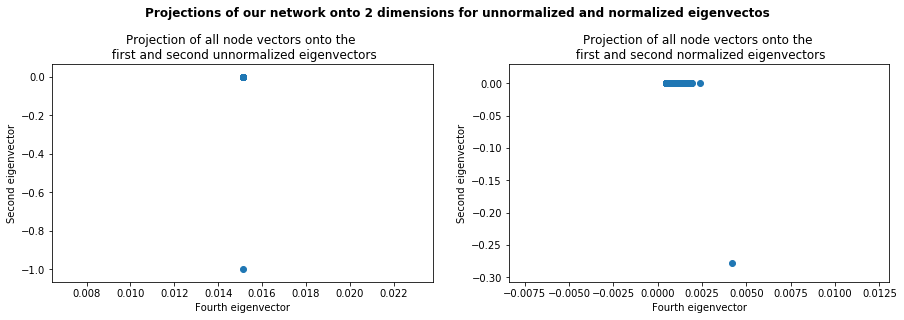

In [32]:
# We plot both projections in order to see which one has more clear clusters
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
f.suptitle("Projections of our network onto 2 dimensions for unnormalized and normalized eigenvectos", y=1.08, fontweight="bold")

ax1.scatter(x=proj_x,y=proj_y)
ax1.set_title("Projection of all node vectors onto the \n first and second unnormalized eigenvectors")
ax1.set_ylabel("Second eigenvector")
ax1.set_xlabel("Fourth eigenvector")

        
ax2.scatter(x=proj_x_norm,y=proj_y_norm)
ax2.set_title("Projection of all node vectors onto the \n first and second normalized eigenvectors")
ax2.set_ylabel("Second eigenvector")
ax2.set_xlabel("Fourth eigenvector")

plt.show()